Este notebook utiliza base de dados previamente preparada a partir da base lista5:

/content/drive/MyDrive/Colab Notebooks/DNC/Projeto TAG2u/trabalho/03 data preparation/base_modelagem_100823.csv

# Instalação de biblioteca

#Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from unidecode import unidecode

from pprint import pprint

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, KFold
#from fast_ml.model_development import train_valid_test_split

import statsmodels.formula.api as smf #metodo de seleção de variaveis

from sklearn import metrics
from sklearn.metrics import r2_score,make_scorer, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

#from google.colab import drive   # To mount google drive
from sklearn.feature_selection import SelectFromModel


#Criando Dataframe

In [2]:
# Importing the dataset(Dataframe creation)
df_original = pd.read_csv('C:\\Users\\carlo\\OneDrive\\git-repositorios\\tag2u\\e-commerce\\automl\\base_dados\\base_modelagem_170823.csv')
df =df_original.copy()

In [3]:
df.head(5)

,valor_venda,valor_individual,quantidade,valor_mercado,material,cor,categoria,titulo,altura,largura,profundidade,SKU,classificacao,tempo_estoque
0,250.0,250.0,1,250.0,couro ecologico,nenhuma,cadeira de escritorio,cadeira de escritorio,110,68,60,4dec223b,moveis escritorio,13.0
1,44.8,56.0,1,140.0,mdp,preto,mesa de telefone,mesa de telefone,60,35,35,04b7370f,moveis,73.0
2,31.2,39.0,1,130.0,mdp,marrom,aparador,aparador,71,33,29,1bedb7af,moveis,87.0
3,420.0,420.0,1,600.0,aco,cinza,arquivo,arquivo c/ 4 gavetas,137,147,60,e53fa86d,moveis escritorio,31.0
4,144.0,144.0,1,180.0,metal,preto,aparelho de som,aparelho de som,23,41,24,ce7f5ade,eletronico,27.0


Convertendo todos os dados dos dataframes para minusculo e retirando os acentos

In [4]:
# Lista das colunas no dataframe df que não são nem numéricas nem datas
colunas_nao_numericas_nem_datas = []

# Percorrer as colunas do dataframe
for coluna in df.columns:
    if not pd.api.types.is_numeric_dtype(df[coluna]) and not pd.api.types.is_datetime64_any_dtype(df[coluna]):
        colunas_nao_numericas_nem_datas.append(coluna)

# Exibir as colunas que não são numéricas, nem datas no dataframe df.
print(colunas_nao_numericas_nem_datas)

['material', 'cor', 'categoria', 'titulo', 'altura', 'largura', 'profundidade', 'SKU', 'classificacao']


In [5]:
# Conversão no dataframe df
# Converter todas as colunas salvas em colunas_nao_numericas_nem_datas para minúsculas e remover acentos
for coluna in colunas_nao_numericas_nem_datas:
    df[coluna] = df[coluna].apply(lambda x: unidecode(str(x).lower()) if pd.notnull(x) else np.nan)

In [6]:
# aplicamos acima a função unidecode() diretamente aos valores de cada célula, dentro de uma função lambda.
#Primeiro, convertemos o valor para minúsculas usando lower(), em seguida, removemos os acentos usando unidecode().
#No entanto, antes de aplicar a função, verificamos se o valor não é nulo usando pd.notnull(x).
#Se o valor for nulo, o próprio valor NaN será preservado.

Eliminando os espaços em branco no início e final de todas as strings em todas as colunas do DataFrame.

In [6]:
# Função para eliminar espaços em branco no início e final de todas as strings no DataFrame
def eliminar_espacos(row):
    return row.apply(lambda x: x.strip() if isinstance(x, str) else x)

# Aplicar a função em todo o DataFrame
df = df.apply(eliminar_espacos)

In [7]:
# Função para substituir strings de acordo com os padrões fornecidos
def replace_strings(text):
    if isinstance(text, str):
        # Converter a string para minúsculas
        text = text.lower()
        # Padrão: ( / ) -> _
        text = re.sub(r'\s/\s', '_', text)
        # Padrão: palavra/palavra -> palavra_palavra
        text = re.sub(r'(\w+)\s?/\s?(\w+)', r'\1_\2', text, flags=re.IGNORECASE)
        # Padrão: ( ler observacoes ) balcao -> balcao
        text = re.sub(r'\( ler observacoes \)\s', '', text)
        # Padrão: palavra palavra -> palavra_palavra
        text = re.sub(r'(\w+)\s(\w+)', r'\1_\2', text)
        # Padrão: 100% palavra -> palavra
        text = re.sub(r'100%\s(\w+)', r'\1', text)
        # Remover espaços em branco adicionais
        text = text.replace(" ", "_")
    return text

# Aplicar a função replace_strings para todas as células do DataFrame para substituir strings de acordo com os padrões fornecidos

df = df.applymap(replace_strings)


In [8]:
# Converter os nomes das colunas para letras minúsculas
df.columns = df.columns.str.lower()

# Remover acentos dos nomes das colunas
df.columns = [unidecode(col) for col in df.columns]

In [9]:
df

,valor_venda,valor_individual,quantidade,valor_mercado,material,cor,categoria,titulo,altura,largura,profundidade,sku,classificacao,tempo_estoque
0,250.0,250.0,1,250.0,couro_ecologico,nenhuma,cadeira_de_escritorio,cadeira_de_escritorio,110,68,60,4dec223b,moveis_escritorio,13.0
1,44.8,56.0,1,140.0,mdp,preto,mesa_de_telefone,mesa_de_telefone,60,35,35,04b7370f,moveis,73.0
2,31.2,39.0,1,130.0,mdp,marrom,aparador,aparador,71,33,29,1bedb7af,moveis,87.0
3,420.0,420.0,1,600.0,aco,cinza,arquivo,arquivo_c_4_gavetas,137,147,60,e53fa86d,moveis_escritorio,31.0
4,144.0,144.0,1,180.0,metal,preto,aparelho_de_som,aparelho_de_som,23,41,24,ce7f5ade,eletronico,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42095,180.0,180.0,1,200.0,metal,branco,microondas,microondas_20_litros,30,48,35,532999a4,eletrodomestico,20.0
42096,188.0,188.0,1,150.0,madeira,nenhuma,sapateira,sapateira_c_3_prateleiras,78,46,30,f3d3a11f,moveis,8.0
42097,150.0,150.0,1,100.0,couro_ecologico,nenhuma,espelho,espelho_c_moldura,51,51,4,4ed6fbe0,utilidades_domesticas,0.0
42098,90.0,90.0,1,60.0,ceramica,amarelo,vaso,vaso,22,16,11,ac65d5a0,decoracao,1.0


# Data Cleaning

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_venda       42100 non-null  float64
 1   valor_individual  42100 non-null  float64
 2   quantidade        42100 non-null  int64  
 3   valor_mercado     42100 non-null  float64
 4   material          40816 non-null  object 
 5   cor               42097 non-null  object 
 6   categoria         42100 non-null  object 
 7   titulo            42099 non-null  object 
 8   altura            41971 non-null  object 
 9   largura           41953 non-null  object 
 10  profundidade      41542 non-null  object 
 11  sku               42099 non-null  object 
 12  classificacao     42100 non-null  object 
 13  tempo_estoque     42100 non-null  float64
dtypes: float64(4), int64(1), object(9)
memory usage: 4.5+ MB


In [11]:
# Copiando o Dataframe df para df1
df1 = df.copy()

In [12]:
#Dropando colunas não necessárias para o modelo
colunas_para_dropar = ['valor_venda', 'quantidade', 'material', 'cor', 'categoria', 'titulo', 'altura', 'largura', 'profundidade', 'sku', 'classificacao']
df1.drop(colunas_para_dropar, axis=1, inplace=True)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  42100 non-null  float64
 1   valor_mercado     42100 non-null  float64
 2   tempo_estoque     42100 non-null  float64
dtypes: float64(3)
memory usage: 986.8 KB


In [14]:
# Remover valores nulos
df1 = df1.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100 entries, 0 to 42099
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  42100 non-null  float64
 1   valor_mercado     42100 non-null  float64
 2   tempo_estoque     42100 non-null  float64
dtypes: float64(3)
memory usage: 986.8 KB


In [15]:
# Remover valores duplicados
df1 = df1.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22213 entries, 0 to 22212
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  22213 non-null  float64
 1   valor_mercado     22213 non-null  float64
 2   tempo_estoque     22213 non-null  float64
dtypes: float64(3)
memory usage: 520.7 KB


In [17]:
#Verificando estatisticas
df1.describe()

,valor_individual,valor_mercado,tempo_estoque
count,22213.000000,22213.000000,22213.000000
mean,282.553175,311.592315,63.528744
std,390.119837,401.882432,74.903379
min,0.000000,0.000000,0.000000
25%,72.000000,100.000000,19.000000
50%,155.000000,180.000000,40.000000
75%,338.000000,373.000000,77.000000
max,14000.000000,14000.000000,816.000000


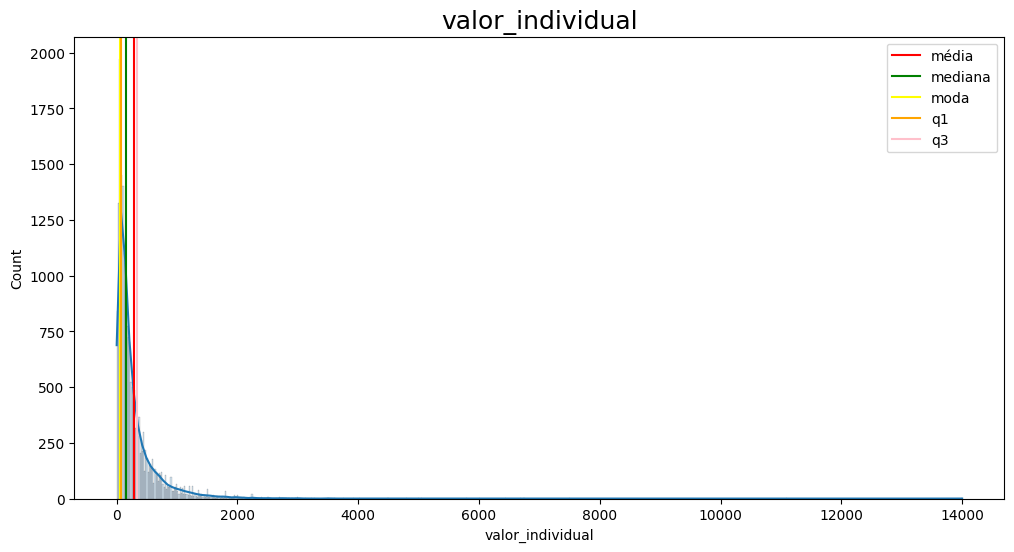

In [19]:
# Valor individual


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_individual", size=18)

# Plot do Histograma
sns.histplot(df1["valor_individual"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["valor_individual"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["valor_individual"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["valor_individual"].mode().shape[0]):
    plt.axvline(df1["valor_individual"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["valor_individual"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["valor_individual"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

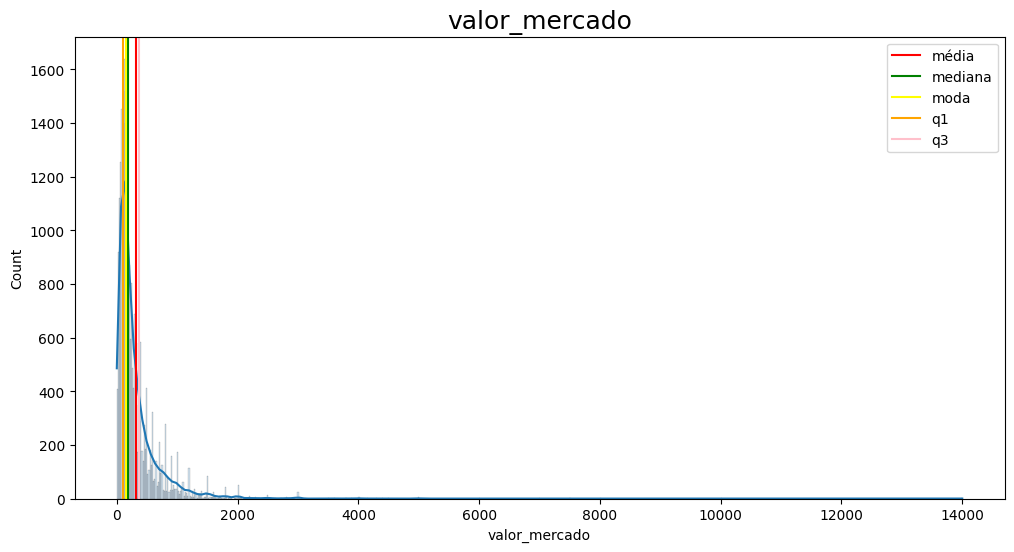

In [20]:
# Valor Mercado


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_mercado", size=18)

# Plot do Histograma
sns.histplot(df1["valor_mercado"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["valor_mercado"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["valor_mercado"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["valor_mercado"].mode().shape[0]):
    plt.axvline(df1["valor_mercado"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["valor_mercado"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["valor_mercado"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

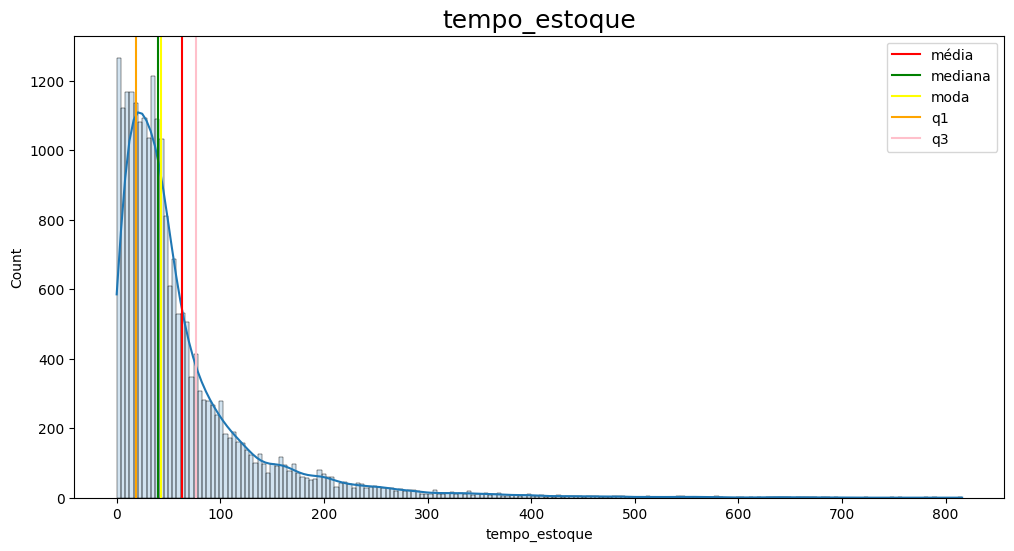

In [21]:
# Tempo Estoque


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("tempo_estoque", size=18)

# Plot do Histograma
sns.histplot(df1["tempo_estoque"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1["tempo_estoque"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1["tempo_estoque"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1["tempo_estoque"].mode().shape[0]):
    plt.axvline(df1["tempo_estoque"].mode()[i], color="yellow", label="moda")

plt.axvline(df1["tempo_estoque"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1["tempo_estoque"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

# OUTLIERS

In [18]:
# Função para tratar outliers via padronização z-score
def zscore_outlier(array):
  scaled_array = scale(array)
  return (scaled_array<-3) | (scaled_array>3)

In [19]:

# Função para identificar outliers nas colunas numéricas
def is_outlier(array, extreme=False):
    q1, q3 = np.quantile(array, [.25, .75])
    iqr = q3 - q1
    factor = 3. if extreme else 1.5
    upper_outlier = q3 + factor * iqr
    lower_outlier = q1 - factor * iqr
    return (array >= lower_outlier) & (array <= upper_outlier)


In [21]:
#Configurando colunas numericas
numerical_features = df1.select_dtypes(include=[np.number]).columns
numerical_features

Index(['valor_individual', 'valor_mercado', 'tempo_estoque'], dtype='object')

(array([1, 2, 3]),
 [Text(1, 0, 'valor_individual'),
  Text(2, 0, 'valor_mercado'),
  Text(3, 0, 'tempo_estoque')])

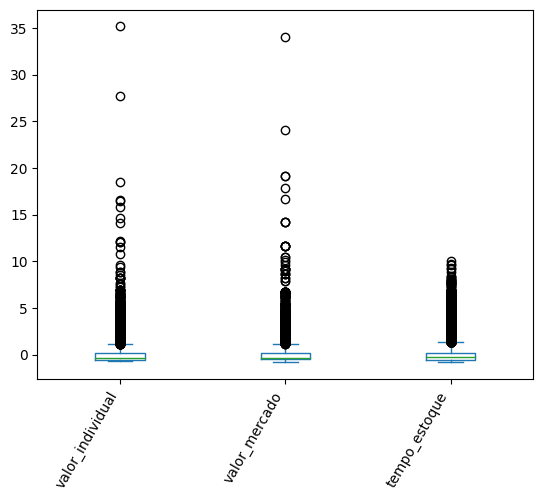

In [22]:
df1[numerical_features].apply(scale).plot.box()
plt.xticks(rotation=60, ha='right')

In [23]:
#Removendo outliers via padronização z-score
df1_without_outliers = df1[~df1[numerical_features].apply(zscore_outlier).any(axis=1)]

# Redefinir os índices para manter a consistência
df1_without_outliers.reset_index(drop=True, inplace=True)

#df1_without_outlier = df1[df1[numerical_features].apply(is_outlier).any(axis=1)]





In [24]:
df1_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21210 entries, 0 to 21209
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  21210 non-null  float64
 1   valor_mercado     21210 non-null  float64
 2   tempo_estoque     21210 non-null  float64
dtypes: float64(3)
memory usage: 497.2 KB


(array([1, 2, 3]),
 [Text(1, 0, 'valor_individual'),
  Text(2, 0, 'valor_mercado'),
  Text(3, 0, 'tempo_estoque')])

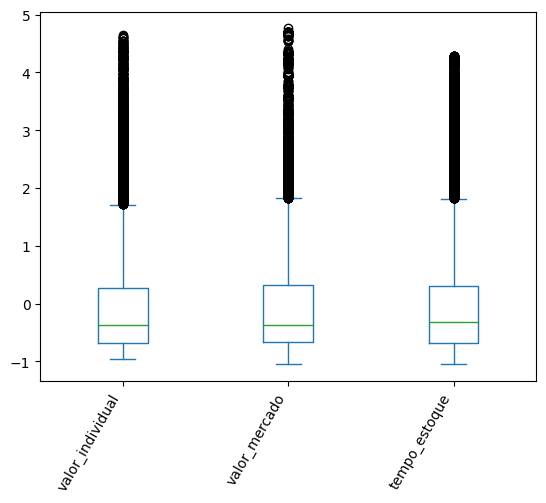

In [25]:
df1_without_outliers[numerical_features].apply(scale).plot.box()
plt.xticks(rotation=60, ha='right')


In [26]:
df1_without_outliers[numerical_features].apply(is_outlier).sum()

valor_individual    19574
valor_mercado       19747
tempo_estoque       19667
dtype: int64

In [27]:
df1_without_outliers.describe()

,valor_individual,valor_mercado,tempo_estoque
count,21210.000000,21210.000000,21210.000000
mean,247.957877,274.481853,56.203159
std,259.034455,260.852802,54.021014
min,0.000000,0.000000,0.000000
25%,72.000000,100.000000,19.000000
50%,152.000000,180.000000,39.500000
75%,320.000000,360.000000,73.000000
max,1450.000000,1516.000000,288.000000


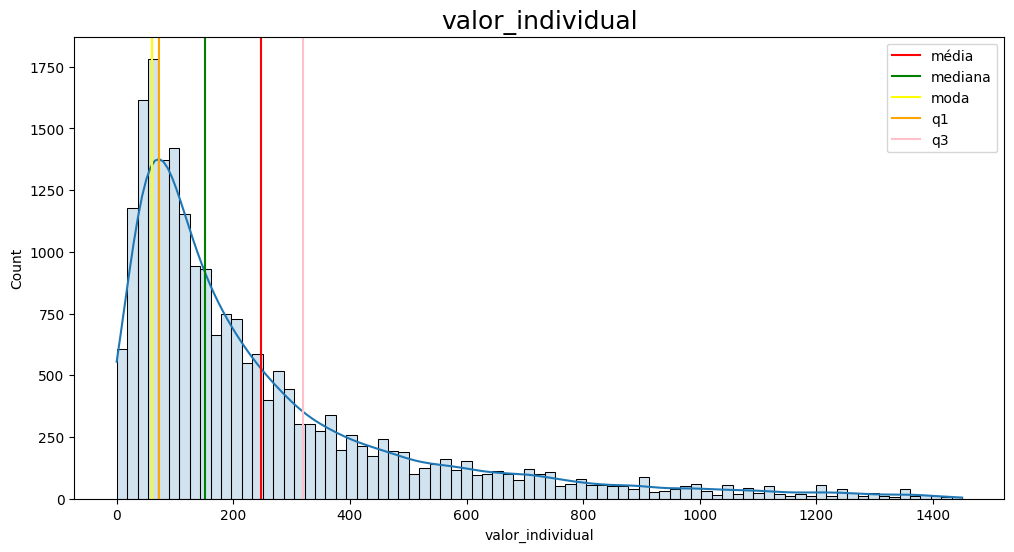

In [40]:
# Valor individual


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_individual", size=18)

# Plot do Histograma
sns.histplot(df1_without_outliers["valor_individual"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1_without_outliers["valor_individual"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1_without_outliers["valor_individual"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1_without_outliers["valor_individual"].mode().shape[0]):
    plt.axvline(df1_without_outliers["valor_individual"].mode()[i], color="yellow", label="moda")

plt.axvline(df1_without_outliers["valor_individual"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1_without_outliers["valor_individual"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()



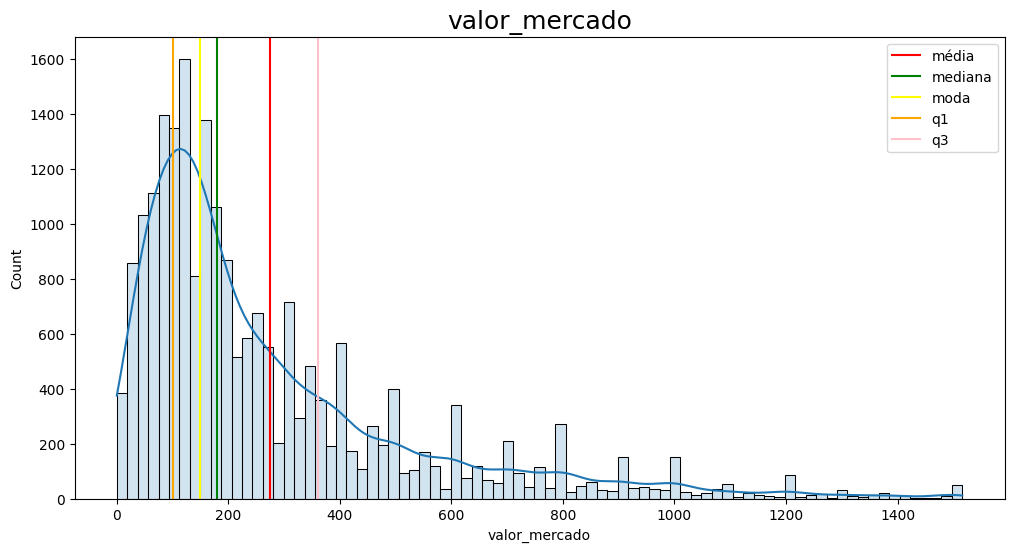

In [41]:
# Valor Mercado


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_mercado", size=18)

# Plot do Histograma
sns.histplot(df1_without_outliers["valor_mercado"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1_without_outliers["valor_mercado"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1_without_outliers["valor_mercado"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1_without_outliers["valor_mercado"].mode().shape[0]):
    plt.axvline(df1_without_outliers["valor_mercado"].mode()[i], color="yellow", label="moda")

plt.axvline(df1_without_outliers["valor_mercado"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1_without_outliers["valor_mercado"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

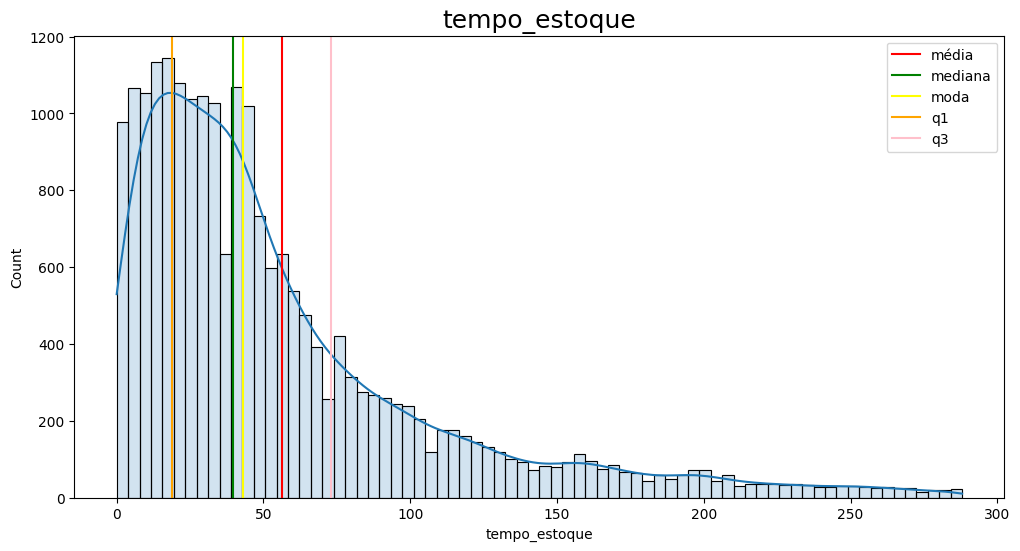

In [42]:
# Tempo Estoque


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("tempo_estoque", size=18)

# Plot do Histograma
sns.histplot(df1_without_outliers["tempo_estoque"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df1_without_outliers["tempo_estoque"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df1_without_outliers["tempo_estoque"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df1_without_outliers["tempo_estoque"].mode().shape[0]):
    plt.axvline(df1_without_outliers["tempo_estoque"].mode()[i], color="yellow", label="moda")

plt.axvline(df1_without_outliers["tempo_estoque"].quantile(0.25), color="orange", label="q1")
plt.axvline(df1_without_outliers["tempo_estoque"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

TRATAMENTO DOS DADOS(NORMALIZAÇÃO)

C:\Users\carlo\AppData\Local\Temp\ipykernel_10540\1286821135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_without_outliers[numerical_features] = df1_without_outliers[numerical_features].apply(np.log)
C:\Users\carlo\AppData\Local\Temp\ipykernel_10540\1286821135.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_without_outliers.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_10540\1286821135.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

Valores infinitos:
       valor_individual  valor_mercado  tempo_estoque
0                   NaN            NaN            NaN
1                   NaN            NaN            NaN
2                   NaN            NaN            NaN
3                   NaN            NaN            NaN
4                   NaN            NaN            NaN
...                 ...            ...            ...
21205               NaN            NaN            NaN
21206               NaN            NaN            NaN
21207               NaN            NaN            NaN
21208               NaN            NaN            NaN
21209               NaN            NaN            NaN

[21210 rows x 3 columns]


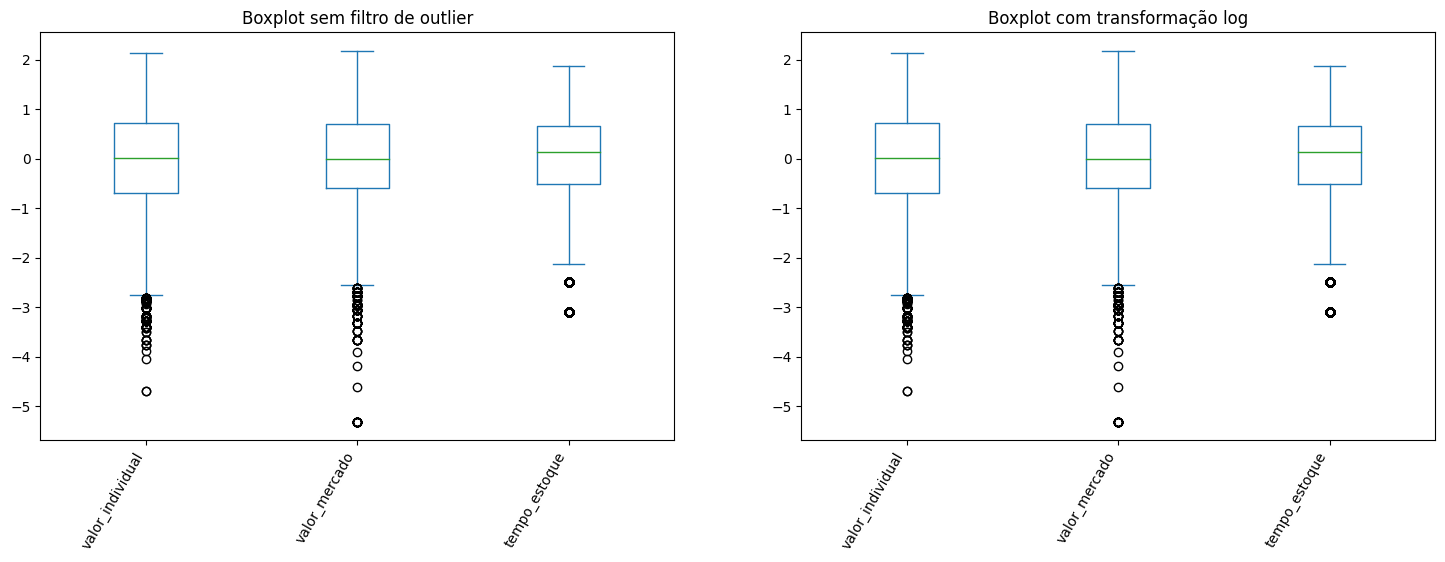

In [43]:
# Aplicar a transformação logarítmica para as colunas numéricas
numerical_features = df1_without_outliers.select_dtypes(include=[np.number]).columns
df1_without_outliers[numerical_features] = df1_without_outliers[numerical_features].apply(np.log)

# Identificar os valores infinitos
inf_positions = np.isinf(df1_without_outliers[numerical_features])

# Exibir os valores infinitos
print("Valores infinitos:")
print(df1_without_outliers[numerical_features][inf_positions])

# Substituir valores infinitos por NaN
df1_without_outliers.replace([np.inf, -np.inf], np.nan, inplace=True)

# Preencher valores NaN com um valor padrão (por exemplo, 0)
df1_without_outliers.fillna(0, inplace=True)

# Padronizar os dados usando a função scale
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
df1_without_outliers[numerical_features].apply(scale).plot.box(ax=axes[0], title='Boxplot sem filtro de outlier')
df1_without_outliers[numerical_features].apply(scale).plot.box(ax=axes[1], title='Boxplot com transformação log')

fig.autofmt_xdate(rotation=60, ha='right')
plt.show()

In [44]:
df1_without_outliers.head(10)

,valor_individual,valor_mercado,tempo_estoque
0,5.521461,5.521461,2.564949
1,4.025352,4.941642,4.290459
2,3.663562,4.867534,4.465908
3,6.040255,6.396930,3.433987
4,4.969813,5.192957,3.295837
5,3.583519,4.499810,4.343805
6,2.995732,3.178054,3.367296
7,4.382027,4.605170,3.332205
8,5.598422,5.598422,2.397895
9,7.034388,6.771936,2.484907


In [38]:
df1_without_outliers.isnull().sum()

valor_individual    0
valor_mercado       0
tempo_estoque       0
dtype: int64

In [45]:
df1_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21210 entries, 0 to 21209
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  21210 non-null  float64
 1   valor_mercado     21210 non-null  float64
 2   tempo_estoque     21210 non-null  float64
dtypes: float64(3)
memory usage: 497.2 KB


In [50]:
df3=df1_without_outliers.copy()
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21210 entries, 0 to 21209
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  21210 non-null  float64
 1   valor_mercado     21210 non-null  float64
 2   tempo_estoque     21210 non-null  float64
dtypes: float64(3)
memory usage: 497.2 KB


In [51]:
df3.isnull().sum()

valor_individual    0
valor_mercado       0
tempo_estoque       0
dtype: int64

In [52]:
df3.describe()

,valor_individual,valor_mercado,tempo_estoque
count,21210.000000,21210.000000,21210.000000
mean,5.007111,5.193429,3.531814
std,1.066312,0.977820,1.142446
min,0.000000,0.000000,0.000000
25%,4.276666,4.605170,2.944439
50%,5.023881,5.192957,3.676221
75%,5.768321,5.886104,4.290459
max,7.279319,7.323831,5.662960


In [54]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21210 entries, 0 to 21209
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   valor_individual  21210 non-null  float64
 1   valor_mercado     21210 non-null  float64
 2   tempo_estoque     21210 non-null  float64
dtypes: float64(3)
memory usage: 497.2 KB


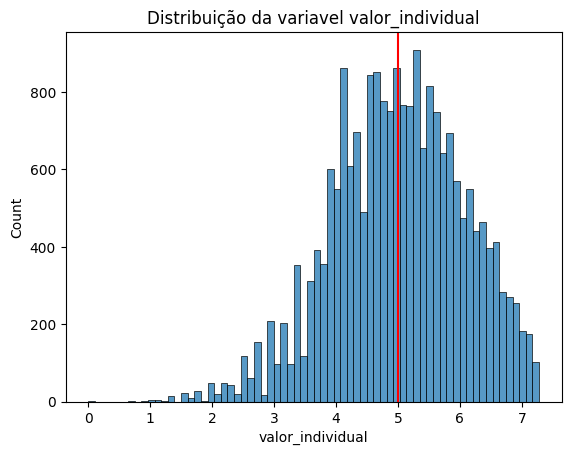

In [55]:
# análise gráfica-> dados quantitativos contínuos

sns.histplot(df3['valor_individual'])
plt.axvline(df3['valor_individual'].mean(), color='red', label='média')

plt.title('Distribuição da variavel valor_individual')
plt.show()

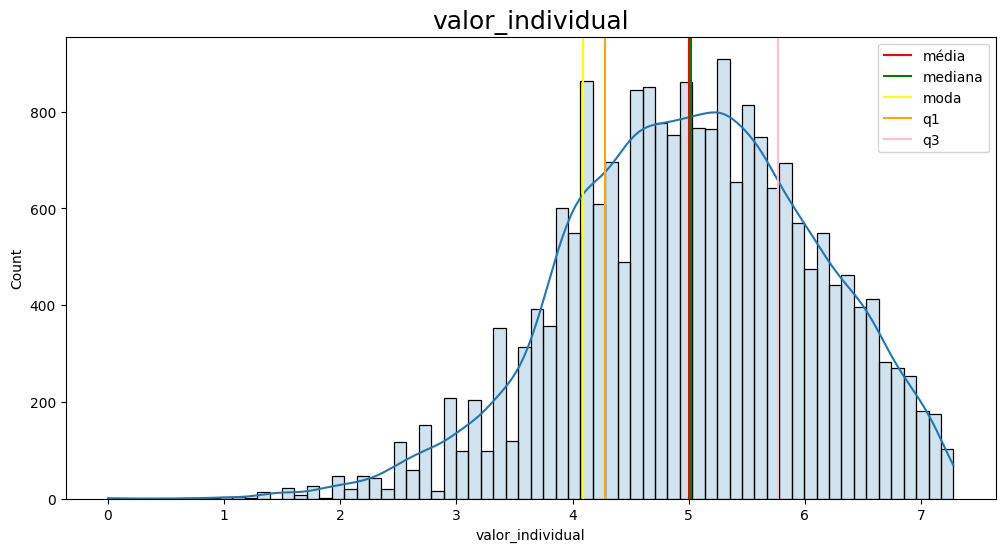

In [56]:
# Valor individual


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_individual", size=18)

# Plot do Histograma
sns.histplot(df3["valor_individual"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df3["valor_individual"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df3["valor_individual"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df3["valor_individual"].mode().shape[0]):
    plt.axvline(df3["valor_individual"].mode()[i], color="yellow", label="moda")

plt.axvline(df3["valor_individual"].quantile(0.25), color="orange", label="q1")
plt.axvline(df3["valor_individual"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

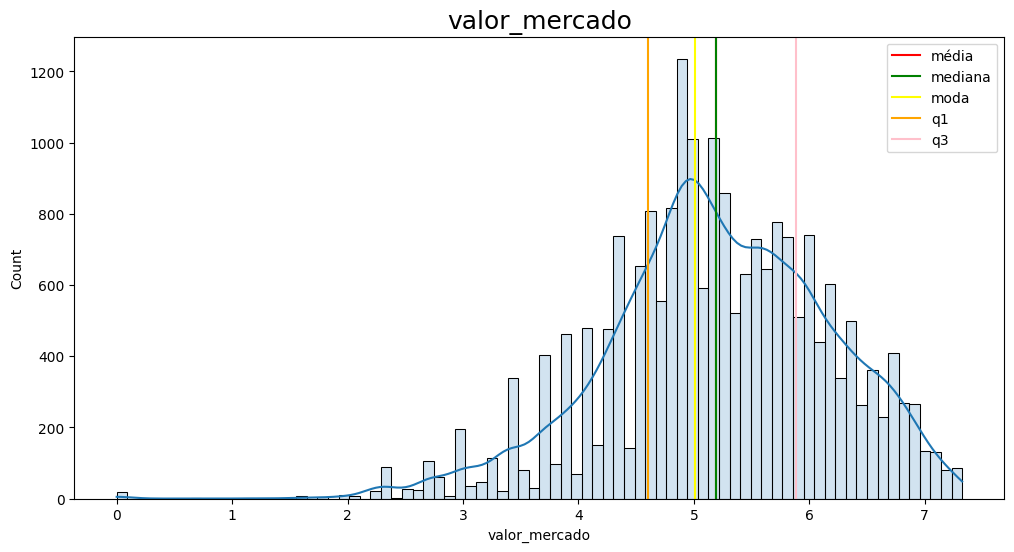

In [57]:
# Valor mercado


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("valor_mercado", size=18)

# Plot do Histograma
sns.histplot(df3["valor_mercado"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df3["valor_mercado"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df3["valor_mercado"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df3["valor_mercado"].mode().shape[0]):
    plt.axvline(df3["valor_mercado"].mode()[i], color="yellow", label="moda")

plt.axvline(df3["valor_mercado"].quantile(0.25), color="orange", label="q1")
plt.axvline(df3["valor_mercado"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

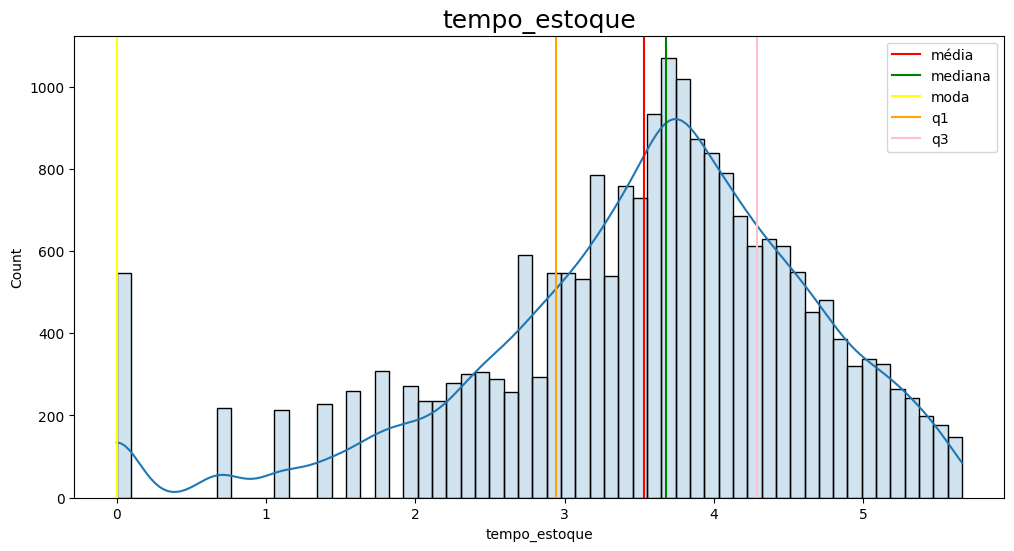

In [58]:
# Tempo Estoque


# Define o tamanho da figura
plt.figure(figsize=(12, 6))

# Define o Titulo
plt.title("tempo_estoque", size=18)

# Plot do Histograma
sns.histplot(df3["tempo_estoque"], kde=True, alpha=0.2)

# plotando média
plt.axvline(x=df3["tempo_estoque"].mean(), color="red", label="média")

# plotando a mediana
plt.axvline(df3["tempo_estoque"].median(), color="green", label="mediana")

# Loop para plotar as modas
for i in range(df3["tempo_estoque"].mode().shape[0]):
    plt.axvline(df3["tempo_estoque"].mode()[i], color="yellow", label="moda")

plt.axvline(df3["tempo_estoque"].quantile(0.25), color="orange", label="q1")
plt.axvline(df3["tempo_estoque"].quantile(0.75), color="pink", label="q3")

# Cria uma legenda
plt.legend()

# Mostra o Gráfico
plt.show()

#Modelando



In [59]:
#Função para o cálculo de R2-ajustado
def adjusted_r2(y_test, y_pred, X_selecionado_train):
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) /
              (len(y_test) - X_selecionado_train.shape[1] - 1))
    return adj_r2

In [60]:
def evaluate_models(X, y, test_size=0.2, random_state=0):

  # Separando os dados de Treino e Teste usando X_selecionado
  X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
  X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=random_state)

  # Defina os modelos que você deseja testar
  models = [
        LinearRegression(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        #SVR(),
        #KNeighborsRegressor(),
        #MLPRegressor(),
        AdaBoostRegressor(),
        GradientBoostingRegressor(),
        XGBRegressor(),
        lgb.LGBMRegressor()
        ]
  # Lista para armazenar as métricas de cada modelo
  lista_metricas = []

  for modelo in models:
    estimador_base = modelo

    # Treinando o Modelo
    estimador_base.fit(X_train, y_train)

    y_pred_train = estimador_base.predict(X_train)
    y_pred_test = estimador_base.predict(X_test)
    y_pred_val = estimador_base.predict(X_val)

    # Coeficiente de Determinação
    r_sq = estimador_base.score(X, y)

    # Calculando as métricas
    metrics_dict = {
        'Modelo': str(modelo),
        'Coef Det R2': r_sq,
        'R2 Adj_train': adjusted_r2(y_train, y_pred_train, X_train),
        'R2 Adj_test': adjusted_r2(y_test, y_pred_test, X_test),
        'R2 Adj_val': adjusted_r2(y_val, y_pred_val, X_val),
        'MSE train': metrics.mean_squared_error(y_train, y_pred_train),
        'MSE test': metrics.mean_squared_error(y_test, y_pred_test),
        'MSE val': metrics.mean_squared_error(y_val, y_pred_val),
        'MAE train': metrics.mean_absolute_error(y_train, y_pred_train),
        'MAE test': metrics.mean_absolute_error(y_test, y_pred_test),
        'MAE val': metrics.mean_absolute_error(y_val, y_pred_val),
        'RMSE train': np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
        'RMSE test': np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),
        'RMSE val': np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))
        }

    # Adicionar o dicionário de métricas à lista
    lista_metricas.append(metrics_dict)
  return lista_metricas

In [61]:
# Cross validation

def evaluate_models_cross(X, y, random_state=0):
    # Defina os modelos que você deseja testar
    models = [
        LinearRegression(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        # SVR(),
        # KNeighborsRegressor(),
        # MLPRegressor(),
        AdaBoostRegressor(),
        GradientBoostingRegressor(),
        XGBRegressor(),
        lgb.LGBMRegressor()
    ]

    # Lista para armazenar as métricas de cada modelo
    lista_metricas_cross = []

    for modelo in models:
        estimador_base = modelo

        # Treinar o seletor
        # modelo.fit(X, y)

        # Validacão cruzada estratificada
        scores = cross_validate(estimador_base, X, y, cv=10, scoring=('r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'), return_train_score=True)

        # Calculando as métricas
        metrics_dict_cross = {
            'Modelo': str(modelo),
            'R2 Train': np.mean(scores['train_r2']),
            'R2 Test': np.mean(scores['test_r2']),
            'MAE train': -np.mean(scores['train_neg_mean_absolute_error']),
            'MAE test': -np.mean(scores['test_neg_mean_absolute_error']),
            'MSE train': -np.mean(scores['train_neg_mean_squared_error']),
            'MSE test': -np.mean(scores['test_neg_mean_squared_error']),
            'RMSE train': np.sqrt(-np.mean(scores['train_neg_mean_squared_error'])),
            'RMSE test': np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        }

        # Adicionar o dicionário de métricas à lista
        lista_metricas_cross.append(metrics_dict_cross)

    return lista_metricas_cross

In [62]:
#K-Fold
from sklearn.model_selection import cross_val_score

def evaluate_models_kfold(X, y, n_splits=5, random_state=0):
    models = [
        LinearRegression(),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        AdaBoostRegressor(),
        GradientBoostingRegressor(),
        XGBRegressor(),
        lgb.LGBMRegressor()
    ]

    lista_metricas_kfold = []

    for modelo in models:
        estimador_base = modelo

        # Perform k-fold cross-validation

        #define cross-validation method to use
        cv = KFold(n_splits=10, random_state=1, shuffle=True)

        scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
        scores = cross_validate(estimador_base, X, y, cv=cv,
                                scoring=scoring, return_train_score=True)

        metrics_dict_kfold = {
            'Modelo': str(modelo),
            'R2 Train': np.mean(scores['train_r2']),
            'R2 Test': np.mean(scores['test_r2']),
            'MAE train': -np.mean(scores['train_neg_mean_absolute_error']),
            'MAE test': -np.mean(scores['test_neg_mean_absolute_error']),
            'MSE train': -np.mean(scores['train_neg_mean_squared_error']),
            'MSE test': -np.mean(scores['test_neg_mean_squared_error']),
            'RMSE train': np.sqrt(-np.mean(scores['train_neg_mean_squared_error'])),
            'RMSE test': np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        }

        lista_metricas_kfold.append(metrics_dict_kfold)

    return lista_metricas_kfold

Dividindo as variáveis em X e y

In [63]:
# 1. Separar os recursos (features) e o alvo (target)
X3 = df3.drop(columns=['valor_individual'])  # Removendo a coluna 'valor_individual'
y3 = df3['valor_individual']


In [64]:
X3

,valor_mercado,tempo_estoque
0,5.521461,2.564949
1,4.941642,4.290459
2,4.867534,4.465908
3,6.396930,3.433987
4,5.192957,3.295837
...,...,...
21205,6.363028,3.737670
21206,6.684612,4.369448
21207,6.396930,3.713572
21208,3.912023,2.639057


Cenário 1: train test Split


Modelando o cenário 3:

In [65]:
# 1. Avaliando o modelo
cenario= evaluate_models(X3, y3, test_size=0.2, random_state=0)
cen_1 =  pd.DataFrame(cenario)
cen_1['cenario'] = 'cen_1'
cen_1

,Modelo,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val,cenario
0,LinearRegression(),0.853854,0.855853,0.859585,0.842366,0.163865,0.155398,0.183822,0.281842,0.273489,0.283199,0.404802,0.394205,0.428745,cen_1
1,DecisionTreeRegressor(),0.901658,0.963065,0.812588,0.806467,0.041987,0.207409,0.225685,0.110100,0.322092,0.329679,0.204907,0.455422,0.475063,cen_1
2,RandomForestRegressor(),0.915348,0.953666,0.861268,0.854490,0.052672,0.153535,0.169684,0.159057,0.284598,0.292366,0.229504,0.391835,0.411927,cen_1
3,AdaBoostRegressor(),0.848481,0.849373,0.850270,0.843959,0.171230,0.165707,0.181965,0.320244,0.315968,0.323760,0.413800,0.407071,0.426573,cen_1
4,GradientBoostingRegressor(),0.891642,0.893229,0.892626,0.885914,0.121376,0.118831,0.133039,0.253055,0.250654,0.257733,0.348391,0.344718,0.364745,cen_1
5,"XGBRegressor(base_score=None, booster=None, ca...",0.902047,0.920575,0.879186,0.869421,0.090290,0.133705,0.152272,0.218016,0.260746,0.268766,0.300482,0.365656,0.390221,cen_1
6,LGBMRegressor(),0.895236,0.901137,0.891065,0.881789,0.112386,0.120559,0.137850,0.241978,0.250783,0.259552,0.335240,0.347216,0.371281,cen_1


cenário2
Cross - Validation

In [66]:
# 2. Avaliando o modelo e exibindo o DataFrame
cenario = evaluate_models_cross(X3, y3, random_state=0)
cen_2 =  pd.DataFrame(cenario)
cen_2['cenario'] = 'cen_2'
cen_2

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
0,LinearRegression(),0.853901,0.844834,0.280815,0.282191,0.166019,0.168195,0.407454,0.410116,cen_2
1,DecisionTreeRegressor(),0.954983,0.800765,0.129601,0.328994,0.051165,0.219005,0.226196,0.467979,cen_2
2,RandomForestRegressor(),0.947301,0.847099,0.169687,0.296062,0.059895,0.167708,0.244734,0.409521,cen_2
3,AdaBoostRegressor(),0.831705,0.818953,0.340431,0.343129,0.191269,0.197554,0.437343,0.444470,cen_2
4,GradientBoostingRegressor(),0.893071,0.881513,0.252407,0.259698,0.121522,0.129733,0.348601,0.360185,cen_2
5,"XGBRegressor(base_score=None, booster=None, ca...",0.913858,0.867043,0.226888,0.269084,0.097902,0.145780,0.312893,0.381812,cen_2
6,LGBMRegressor(),0.899214,0.878646,0.243273,0.260540,0.114540,0.132745,0.338438,0.364341,cen_2


Cenário 3: K-fold

In [67]:
# 2. Avaliando o modelo e exibindo o DataFrame
cenario = evaluate_models_kfold(X3, y3, n_splits=5, random_state=0)
cen_3 =  pd.DataFrame(cenario)
cen_3['cenario'] = 'cen_3'
cen_3

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
0,LinearRegression(),0.853888,0.853609,0.280824,0.280869,0.166121,0.166220,0.407580,0.407701,cen_3
1,DecisionTreeRegressor(),0.954917,0.816001,0.129611,0.320841,0.051259,0.208909,0.226404,0.457066,cen_3
2,RandomForestRegressor(),0.947269,0.858096,0.169852,0.288939,0.059953,0.161139,0.244854,0.401421,cen_3
3,AdaBoostRegressor(),0.830242,0.826254,0.342290,0.343255,0.192994,0.197460,0.439310,0.444364,cen_3
4,GradientBoostingRegressor(),0.892993,0.888319,0.252508,0.256638,0.121661,0.126801,0.348800,0.356092,cen_3
5,"XGBRegressor(base_score=None, booster=None, ca...",0.913246,0.879007,0.227932,0.262811,0.098636,0.137452,0.314064,0.370746,cen_3
6,LGBMRegressor(),0.899083,0.887478,0.243499,0.255519,0.114738,0.127787,0.338729,0.357472,cen_3


In [68]:
#Criando dataframes com as métricas dos modelos
cen_cross = pd.concat([cen_2, cen_3])


Análise dos resultados

In [69]:
#Melhores resultados de R2 ajustado na validação nos cenários 1,2 e 3.
cen_1.nlargest(3, 'R2 Adj_val')

,Modelo,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val,cenario
4,GradientBoostingRegressor(),0.891642,0.893229,0.892626,0.885914,0.121376,0.118831,0.133039,0.253055,0.250654,0.257733,0.348391,0.344718,0.364745,cen_1
6,LGBMRegressor(),0.895236,0.901137,0.891065,0.881789,0.112386,0.120559,0.137850,0.241978,0.250783,0.259552,0.335240,0.347216,0.371281,cen_1
5,"XGBRegressor(base_score=None, booster=None, ca...",0.902047,0.920575,0.879186,0.869421,0.090290,0.133705,0.152272,0.218016,0.260746,0.268766,0.300482,0.365656,0.390221,cen_1


In [70]:
#Melhores resultados de R2 de teste nos cenários 4, 5 e 6.
cen_cross.nlargest(3, 'R2 Test')

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
4,GradientBoostingRegressor(),0.892993,0.888319,0.252508,0.256638,0.121661,0.126801,0.348800,0.356092,cen_3
6,LGBMRegressor(),0.899083,0.887478,0.243499,0.255519,0.114738,0.127787,0.338729,0.357472,cen_3
4,GradientBoostingRegressor(),0.893071,0.881513,0.252407,0.259698,0.121522,0.129733,0.348601,0.360185,cen_2


In [71]:
#Melhores resultados de MSE na validação nos cenários 1,2 e 3.
cen_1.nsmallest(3, 'MSE val')

,Modelo,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val,cenario
4,GradientBoostingRegressor(),0.891642,0.893229,0.892626,0.885914,0.121376,0.118831,0.133039,0.253055,0.250654,0.257733,0.348391,0.344718,0.364745,cen_1
6,LGBMRegressor(),0.895236,0.901137,0.891065,0.881789,0.112386,0.120559,0.137850,0.241978,0.250783,0.259552,0.335240,0.347216,0.371281,cen_1
5,"XGBRegressor(base_score=None, booster=None, ca...",0.902047,0.920575,0.879186,0.869421,0.090290,0.133705,0.152272,0.218016,0.260746,0.268766,0.300482,0.365656,0.390221,cen_1


In [72]:
#Melhores resultados de MSE de teste nos cenários 4, 5 e 6.
cen_cross.nsmallest(3, 'MSE test')

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
4,GradientBoostingRegressor(),0.892993,0.888319,0.252508,0.256638,0.121661,0.126801,0.348800,0.356092,cen_3
6,LGBMRegressor(),0.899083,0.887478,0.243499,0.255519,0.114738,0.127787,0.338729,0.357472,cen_3
4,GradientBoostingRegressor(),0.893071,0.881513,0.252407,0.259698,0.121522,0.129733,0.348601,0.360185,cen_2


In [73]:
#Melhores resultados de MAE na validação nos cenários 1,2 e 3.
cen_1.nsmallest(3, 'MAE val')

,Modelo,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val,cenario
4,GradientBoostingRegressor(),0.891642,0.893229,0.892626,0.885914,0.121376,0.118831,0.133039,0.253055,0.250654,0.257733,0.348391,0.344718,0.364745,cen_1
6,LGBMRegressor(),0.895236,0.901137,0.891065,0.881789,0.112386,0.120559,0.137850,0.241978,0.250783,0.259552,0.335240,0.347216,0.371281,cen_1
5,"XGBRegressor(base_score=None, booster=None, ca...",0.902047,0.920575,0.879186,0.869421,0.090290,0.133705,0.152272,0.218016,0.260746,0.268766,0.300482,0.365656,0.390221,cen_1


In [74]:
#Melhores resultados de MAE de teste nos cenários 4, 5 e 6.
cen_cross.nsmallest(3, 'MAE test')

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
6,LGBMRegressor(),0.899083,0.887478,0.243499,0.255519,0.114738,0.127787,0.338729,0.357472,cen_3
4,GradientBoostingRegressor(),0.892993,0.888319,0.252508,0.256638,0.121661,0.126801,0.348800,0.356092,cen_3
4,GradientBoostingRegressor(),0.893071,0.881513,0.252407,0.259698,0.121522,0.129733,0.348601,0.360185,cen_2


In [75]:
#Melhores resultados de RMSE na validação nos cenários 1,2 e 3.
cen_1.nsmallest(3, 'RMSE val')

,Modelo,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val,cenario
4,GradientBoostingRegressor(),0.891642,0.893229,0.892626,0.885914,0.121376,0.118831,0.133039,0.253055,0.250654,0.257733,0.348391,0.344718,0.364745,cen_1
6,LGBMRegressor(),0.895236,0.901137,0.891065,0.881789,0.112386,0.120559,0.137850,0.241978,0.250783,0.259552,0.335240,0.347216,0.371281,cen_1
5,"XGBRegressor(base_score=None, booster=None, ca...",0.902047,0.920575,0.879186,0.869421,0.090290,0.133705,0.152272,0.218016,0.260746,0.268766,0.300482,0.365656,0.390221,cen_1


In [76]:
#Melhores resultados de RMSE de teste nos cenários 4, 5 e 6.
cen_cross.nsmallest(3, 'RMSE test')

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
4,GradientBoostingRegressor(),0.892993,0.888319,0.252508,0.256638,0.121661,0.126801,0.348800,0.356092,cen_3
6,LGBMRegressor(),0.899083,0.887478,0.243499,0.255519,0.114738,0.127787,0.338729,0.357472,cen_3
4,GradientBoostingRegressor(),0.893071,0.881513,0.252407,0.259698,0.121522,0.129733,0.348601,0.360185,cen_2


#Aplicando regressão GradientBoostingRegressor()	

1. Separar os recursos (features) e o alvo (target)


Conforme "cenário 3 " X3 e y3


In [88]:
#configuração do modelo  regressor
modelo = 	GradientBoostingRegressor()

In [91]:
def evaluate_models(X, y, test_size=0.2, random_state=0):

  # Separando os dados de Treino e Teste usando X_selecionado
  X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
  X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=random_state)

  # Defina os modelos que você deseja testar
  models = [
        #LinearRegression(),
        #DecisionTreeRegressor(),
        #RandomForestRegressor(),
        #SVR(),
        #KNeighborsRegressor(),
        #MLPRegressor(),
        #AdaBoostRegressor(),
        GradientBoostingRegressor(),
        #XGBRegressor(),
        #lgb.LGBMRegressor()
        ]
  # Lista para armazenar as métricas de cada modelo
  lista_metricas = []

  for modelo in models:
    estimador_base = modelo

    # Treinando o Modelo
    estimador_base.fit(X_train, y_train)

    y_pred_train = estimador_base.predict(X_train)
    y_pred_test = estimador_base.predict(X_test)
    y_pred_val = estimador_base.predict(X_val)

    # Coeficiente de Determinação
    r_sq = estimador_base.score(X, y)

    # Calculando as métricas
    metrics_dict = {
        'Modelo': str(modelo),
        'Coef Det R2': r_sq,
        'R2 Adj_train': adjusted_r2(y_train, y_pred_train, X_train),
        'R2 Adj_test': adjusted_r2(y_test, y_pred_test, X_test),
        'R2 Adj_val': adjusted_r2(y_val, y_pred_val, X_val),
        'MSE train': metrics.mean_squared_error(y_train, y_pred_train),
        'MSE test': metrics.mean_squared_error(y_test, y_pred_test),
        'MSE val': metrics.mean_squared_error(y_val, y_pred_val),
        'MAE train': metrics.mean_absolute_error(y_train, y_pred_train),
        'MAE test': metrics.mean_absolute_error(y_test, y_pred_test),
        'MAE val': metrics.mean_absolute_error(y_val, y_pred_val),
        'RMSE train': np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
        'RMSE test': np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),
        'RMSE val': np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))
        }
    # Plotagem do gráfico de comparação entre y_train e y_pred_train
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_pred_train, c='blue', label='Observado vs. Previsto')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3, c='red', label='Linha de Referência')
    plt.xlabel('Observado (y_train)')
    plt.ylabel('Previsto (y_pred_train)')
    plt.title(f'Comparação entre y_train e y_pred_train - {str(modelo)}')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Adicionar o dicionário de métricas à lista
    lista_metricas.append(metrics_dict)
  return estimador_base , lista_metricas

C:\Users\carlo\AppData\Local\Temp\ipykernel_10540\1015481017.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3, c='red', label='Linha de Referência')


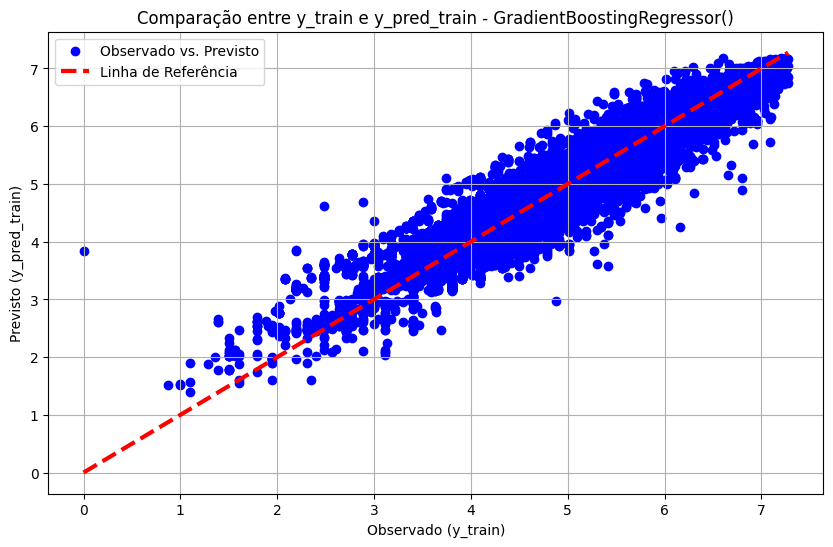

,Modelo,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val,cenario
0,GradientBoostingRegressor(),0.891638,0.893229,0.892617,0.885907,0.121376,0.118841,0.133048,0.253055,0.25066,0.257739,0.348391,0.344733,0.364757,cen


In [92]:
# 1. Avaliando o modelo e exibindo o DataFrame
modelo, cenario = evaluate_models(X3, y3, test_size=0.2, random_state=0)

cen =  pd.DataFrame(cenario)
cen['cenario'] = 'cen'
cen

In [96]:
np.exp(5.52)

249.6350371896937

In [93]:
print(type(modelo))

<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


#Salvando o modelo

In [94]:
import joblib

# Salvar o modelo usando joblib
joblib.dump(modelo, 'c:/Users/carlo/OneDrive/git-repositorios/tag2u/e-commerce_regressao/pipelines/modelos/precificacao_270923_joblib_vm_tempoestoque.pkl')

['c:/Users/carlo/OneDrive/git-repositorios/tag2u/e-commerce_regressao/pipelines/modelos/precificacao_270923_joblib_vm_tempoestoque.pkl']

##ANTIGO

In [ ]:
#configuração do modelo  regressor
modelo = 	LGBMRegressor()
modelo.fit(X3,y3)

# Perform k-fold cross-validation

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
scores = cross_validate(modelo, X3, y3, cv=cv,scoring=scoring, return_train_score=True)

lista_metricas_kfold = []
metrics_dict_kfold = {
            'Modelo': str(modelo),
            'R2 Train': np.mean(scores['train_r2']),
            'R2 Test': np.mean(scores['test_r2']),
            'MAE train': -np.mean(scores['train_neg_mean_absolute_error']),
            'MAE test': -np.mean(scores['test_neg_mean_absolute_error']),
            'MSE train': -np.mean(scores['train_neg_mean_squared_error']),
            'MSE test': -np.mean(scores['test_neg_mean_squared_error']),
            'RMSE train': np.sqrt(-np.mean(scores['train_neg_mean_squared_error'])),
            'RMSE test': np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        }
lista_metricas_kfold.append(metrics_dict_kfold)


#Visualização da importância de cada variável para o modelo

In [ ]:
# Acessar a importância das features
importances = modelo.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
importances_df = pd.DataFrame({
    'Feature': X3.columns,
    'Importance': importances
})

# Ordenar as importâncias em ordem decrescente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

,Feature,Importance
0,valor_mercado,0.791522
7,tempo_estoque,0.140170
2,titulo,0.015046
4,largura,0.014009
3,altura,0.013962
5,profundidade,0.012455
1,material,0.008859
6,classificacao,0.003976


Observa-se que 🇰

Valor_mercado:  contribui com 79% para o resultado do modelo.

Temp_estoque:  Contribui com 13,99% para o resultado do modelo.

Variáveis altura, largura e profundidade, juntas, contribuem com  4,2% para o resultado do modelo.

As demais variaveis, juntas,  tem participação  muito pequena para o resultado do modelo.

In [ ]:
cen_rf =  pd.DataFrame(lista_metricas_kfold)
cen_rf

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test
0,RandomForestRegressor(),0.988635,0.924279,0.065937,0.174264,0.010567,0.070347,0.102796,0.26523


#ATenção, rever otimização pois é de outro cenário

Realizando otimização do modelo RandomForestRegressor()

In [ ]:
#Visualizando parametros do RandomForest

pprint("Parâmetros da RandomForest:")
pprint(modelo.get_params())

'Parâmetros da RandomForest:'
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Criando lista de parametros para ser utilizada pelo modelo

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [0]  # Para reprodutibilidade
}

In [ ]:
#4. Criar o modelo base
modelo = RandomForestRegressor()

Configurando o Random_search para uso dos parametros anteriormente definidos.

In [ ]:
# Realizar a otimização usando RandomizedSearchCV
random_search = RandomizedSearchCV(
    modelo, param_distributions=param_grid, n_iter=10, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2, random_state=0
)

In [ ]:
# Treinar o modelo com a otimização
random_search.fit(df3.drop(columns=['valor_individual']), df3['valor_individual'])


In [ ]:
# Exibir os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(random_search.best_params_)

In [ ]:
# Exibir o MSE do melhor modelo encontrado
best_model = random_search.best_estimator_
best_mse = -random_search.best_score_
print("MSE do Melhor Modelo:", best_mse)

Nota: o resultado acima não é melhor que o encontrado na fase de escolha do modelo.

Configurando o modelo com os melhores parametros encontrados

In [ ]:
rf_tun = RandomForestRegressor(
    random_state = 0,
    n_estimators = 200,
    min_samples_split = 2,
    min_samples_leaf = 2,
    max_features = 'sqrt',
    max_depth = None
)


Treinando o modelo com parametros de otimização escolhidos

In [ ]:
rf_tun.fit(X_train, y_train)

In [ ]:
# Lista para armazenar as métricas de cada modelo
lista_metricas_tunadas = []


In [ ]:
#Predições Tunadas
y_pred_train= rf_tun.predict(X_train)
y_pred_test= rf_tun.predict(X_test)
y_pred_val = rf_tun.predict(X_val)

In [ ]:
#Métricas Tunadas

# Calculando as métricas
metrics_dict = {
    'Coef Det R2': rf_tun.score(X3, y3),
    'R2 Adj_train': adjusted_r2(y_train, y_pred_train, X_train),
    'R2 Adj_test': adjusted_r2(y_test, y_pred_test, X_test),
    'R2 Adj_val': adjusted_r2(y_val, y_pred_val, X_val),
    'MSE train': metrics.mean_squared_error(y_train, y_pred_train),
    'MSE test': metrics.mean_squared_error(y_test, y_pred_test),
    'MSE val': metrics.mean_squared_error(y_val, y_pred_val),
    'MAE train': metrics.mean_absolute_error(y_train, y_pred_train),
    'MAE test': metrics.mean_absolute_error(y_test, y_pred_test),
    'MAE val': metrics.mean_absolute_error(y_val, y_pred_val),
    'RMSE train': np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
    'RMSE test': np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),
    'RMSE val': np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))
    }
# Adicionar o dicionário de métricas à lista
lista_metricas_tunadas.append(metrics_dict)

cen_gradiente_tunadas =  pd.DataFrame(lista_metricas_tunadas)
cen_gradiente_tunadas

In [ ]:
#antes da otimizacao
cen_rf

In [ ]:
cen_train_test_split.nlargest(1, 'R2 Adj_val')

Resultados da otimização
Os resultados das métricas na otimização não foram melhores que os encontrados na fase de seleção do modelo.  Os parametros de otimização precisam ser revistos para melhorar o modelo.

VAmos ver cenários sem as variáveis valor_mercado, tempo_estoque.

Vamos partir do cenário09

Cenário 10 sem variável valor mercado

In [ ]:
# Mesmas variaveis que o cenário 3 e 6 9 - retirando-se valor_mercado
X3

,valor_mercado,material,titulo,altura,largura,profundidade,classificacao,tempo_estoque
0,5.521461,4.060443,8.058327,4.700480,4.219508,4.094345,2.995732,2.564949
1,5.192957,4.882802,5.926926,3.135494,3.713572,3.178054,2.397895,3.295837
2,4.499810,4.875197,9.248503,4.290459,4.356709,4.043051,2.890372,4.343805
3,3.178054,4.867534,9.505991,3.091042,2.833213,0.693147,1.945910,3.367296
4,4.605170,4.875197,7.067320,4.330733,3.713572,3.637586,2.995732,3.332205
...,...,...,...,...,...,...,...,...
32240,5.480639,4.718499,8.004700,4.812184,5.093750,2.397895,2.890372,3.610918
32241,5.298317,4.882802,9.363061,3.401197,3.871201,3.555348,2.197225,2.995732
32242,5.010635,4.718499,9.559235,4.356709,3.828641,3.401197,2.890372,2.079442
32243,4.605170,4.060443,8.739857,3.931826,3.931826,1.386294,3.218876,0.000000


In [ ]:
X3_1 = X3.drop(columns=['valor_mercado'])
X3_1

,material,titulo,altura,largura,profundidade,classificacao,tempo_estoque
0,4.060443,8.058327,4.700480,4.219508,4.094345,2.995732,2.564949
1,4.882802,5.926926,3.135494,3.713572,3.178054,2.397895,3.295837
2,4.875197,9.248503,4.290459,4.356709,4.043051,2.890372,4.343805
3,4.867534,9.505991,3.091042,2.833213,0.693147,1.945910,3.367296
4,4.875197,7.067320,4.330733,3.713572,3.637586,2.995732,3.332205
...,...,...,...,...,...,...,...
32240,4.718499,8.004700,4.812184,5.093750,2.397895,2.890372,3.610918
32241,4.882802,9.363061,3.401197,3.871201,3.555348,2.197225,2.995732
32242,4.718499,9.559235,4.356709,3.828641,3.401197,2.890372,2.079442
32243,4.060443,8.739857,3.931826,3.931826,1.386294,3.218876,0.000000


In [ ]:
# 2. Avaliando o modelo e exibindo o DataFrame
cenario = evaluate_models_kfold(X3_1, y3, n_splits=5, random_state=0)
cen_10 =  pd.DataFrame(cenario)
cen_10['cenario'] = 'cen_10'
cen_10

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] Start training from score 5.033859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] Start training from score 5.031702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] Sta

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
0,LinearRegression(),0.400383,0.399536,0.569610,0.569848,0.557497,0.557954,0.746657,0.746963,cen_10
1,DecisionTreeRegressor(),0.998734,0.453147,0.003746,0.489402,0.001178,0.508079,0.034315,0.712796,cen_10
2,RandomForestRegressor(),0.960847,0.724480,0.135049,0.360087,0.036403,0.255984,0.190795,0.505948,cen_10
3,AdaBoostRegressor(),0.446870,0.440275,0.561033,0.562995,0.514284,0.519989,0.717136,0.721103,cen_10
4,GradientBoostingRegressor(),0.629372,0.617537,0.444803,0.450668,0.344591,0.355346,0.587019,0.596109,cen_10
5,"XGBRegressor(base_score=None, booster=None, ca...",0.824735,0.730568,0.304026,0.370205,0.162953,0.250328,0.403674,0.500328,cen_10
6,LGBMRegressor(),0.734801,0.698693,0.374548,0.396473,0.246570,0.279905,0.496558,0.529060,cen_10


Cenário 11: sem a variável tempo_estoque

In [ ]:
X3_2 = X3.drop(columns=['tempo_estoque'])
X3_2

,valor_mercado,material,titulo,altura,largura,profundidade,classificacao
0,5.521461,4.060443,8.058327,4.700480,4.219508,4.094345,2.995732
1,5.192957,4.882802,5.926926,3.135494,3.713572,3.178054,2.397895
2,4.499810,4.875197,9.248503,4.290459,4.356709,4.043051,2.890372
3,3.178054,4.867534,9.505991,3.091042,2.833213,0.693147,1.945910
4,4.605170,4.875197,7.067320,4.330733,3.713572,3.637586,2.995732
...,...,...,...,...,...,...,...
32240,5.480639,4.718499,8.004700,4.812184,5.093750,2.397895,2.890372
32241,5.298317,4.882802,9.363061,3.401197,3.871201,3.555348,2.197225
32242,5.010635,4.718499,9.559235,4.356709,3.828641,3.401197,2.890372
32243,4.605170,4.060443,8.739857,3.931826,3.931826,1.386294,3.218876


In [ ]:
# 2. Avaliando o modelo e exibindo o DataFrame
cenario = evaluate_models_kfold(X3_2, y3, n_splits=5, random_state=0)
cen_11 =  pd.DataFrame(cenario)
cen_11['cenario'] = 'cen_11'
cen_11

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] Start training from score 5.033859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] Start training from score 5.031702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1337
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 7
[LightGBM] [Info] Sta

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
0,LinearRegression(),0.781784,0.781430,0.352610,0.352728,0.202887,0.203031,0.450429,0.450589,cen_11
1,DecisionTreeRegressor(),0.977240,0.690061,0.056007,0.381150,0.021161,0.287902,0.145468,0.536565,cen_11
2,RandomForestRegressor(),0.957314,0.814671,0.143123,0.312746,0.039688,0.172121,0.199217,0.414875,cen_11
3,AdaBoostRegressor(),0.702455,0.700932,0.438892,0.439659,0.276636,0.277899,0.525962,0.527161,cen_11
4,GradientBoostingRegressor(),0.801227,0.796901,0.335222,0.338687,0.184809,0.188661,0.429894,0.434352,cen_11
5,"XGBRegressor(base_score=None, booster=None, ca...",0.863138,0.813663,0.273175,0.319999,0.127247,0.173080,0.356717,0.416028,cen_11
6,LGBMRegressor(),0.828087,0.810111,0.310848,0.325889,0.159837,0.176387,0.399796,0.419984,cen_11


cenário 12: Sem valor_mercado e tempo_estoque

In [ ]:
X3_3 = X3.drop(columns=['tempo_estoque', 'valor_mercado'])
X3_3

,material,titulo,altura,largura,profundidade,classificacao
0,4.060443,8.058327,4.700480,4.219508,4.094345,2.995732
1,4.882802,5.926926,3.135494,3.713572,3.178054,2.397895
2,4.875197,9.248503,4.290459,4.356709,4.043051,2.890372
3,4.867534,9.505991,3.091042,2.833213,0.693147,1.945910
4,4.875197,7.067320,4.330733,3.713572,3.637586,2.995732
...,...,...,...,...,...,...
32240,4.718499,8.004700,4.812184,5.093750,2.397895,2.890372
32241,4.882802,9.363061,3.401197,3.871201,3.555348,2.197225
32242,4.718499,9.559235,4.356709,3.828641,3.401197,2.890372
32243,4.060443,8.739857,3.931826,3.931826,1.386294,3.218876


In [ ]:
# 2. Avaliando o modelo e exibindo o DataFrame
cenario = evaluate_models_kfold(X3_3, y3, n_splits=5, random_state=0)
cen_12 =  pd.DataFrame(cenario)
cen_12['cenario'] = 'cen_12'
cen_12

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 6
[LightGBM] [Info] Start training from score 5.033859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1108
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 6
[LightGBM] [Info] Start training from score 5.031702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 29020, number of used features: 6
[LightGBM] [Info] Sta

,Modelo,R2 Train,R2 Test,MAE train,MAE test,MSE train,MSE test,RMSE train,RMSE test,cenario
0,LinearRegression(),0.311807,0.310875,0.621437,0.621657,0.639851,0.640345,0.799907,0.800216,cen_12
1,DecisionTreeRegressor(),0.974560,0.443500,0.062632,0.504567,0.023653,0.517005,0.153794,0.719031,cen_12
2,RandomForestRegressor(),0.935845,0.674562,0.180462,0.404983,0.059648,0.302295,0.244229,0.549813,cen_12
3,AdaBoostRegressor(),0.400862,0.397193,0.586010,0.586517,0.557046,0.560204,0.746355,0.748468,cen_12
4,GradientBoostingRegressor(),0.551153,0.539323,0.501797,0.507689,0.417316,0.427974,0.646000,0.654197,cen_12
5,"XGBRegressor(base_score=None, booster=None, ca...",0.752549,0.655211,0.367890,0.431103,0.230070,0.320275,0.479657,0.565929,cen_12
6,LGBMRegressor(),0.657891,0.621736,0.436145,0.456495,0.318077,0.351391,0.563983,0.592783,cen_12


In [ ]:
import numpy as np
np.exp(5.48)

239.84670737425537

TESTES ADCIONAIS

In [ ]:
#configuração do modelo  regressor
modelo = RandomForestRegressor()
modelo.fit(X3_3,y3)

# Perform k-fold cross-validation

#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
scores = cross_validate(modelo, X3_3, y3, cv=cv,scoring=scoring, return_train_score=True)

lista_metricas_kfold = []
metrics_dict_kfold = {
            'Modelo': str(modelo),
            'R2 Train': np.mean(scores['train_r2']),
            'R2 Test': np.mean(scores['test_r2']),
            'MAE train': -np.mean(scores['train_neg_mean_absolute_error']),
            'MAE test': -np.mean(scores['test_neg_mean_absolute_error']),
            'MSE train': -np.mean(scores['train_neg_mean_squared_error']),
            'MSE test': -np.mean(scores['test_neg_mean_squared_error']),
            'RMSE train': np.sqrt(-np.mean(scores['train_neg_mean_squared_error'])),
            'RMSE test': np.sqrt(-np.mean(scores['test_neg_mean_squared_error']))
        }
lista_metricas_kfold.append(metrics_dict_kfold)


In [ ]:
# Acessar a importância das features
importances = modelo.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
importances_df = pd.DataFrame({
    'Feature': X3_3.columns,
    'Importance': importances
})

# Ordenar as importâncias em ordem decrescente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

In [ ]:
cen_rf =  pd.DataFrame(lista_metricas_kfold)
cen_rf

cenario 13 para ver a volta do logaritmo

In [ ]:
X_main, X_test, y_main, y_test = train_test_split(X3_3, y3, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.25, random_state=0)

In [ ]:
model = RandomForestRegressor()

In [ ]:
  lista_metricas = []

In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

In [ ]:
# Coeficiente de Determinação
r_sq = model.score(X3_3, y3)

In [ ]:
metrics_dict = {
        'Coef Det R2': r_sq,
        'R2 Adj_train': adjusted_r2(y_train, y_pred_train, X_train),
        'R2 Adj_test': adjusted_r2(y_test, y_pred_test, X_test),
        'R2 Adj_val': adjusted_r2(y_val, y_pred_val, X_val),
        'MSE train': metrics.mean_squared_error(y_train, y_pred_train),
        'MSE test': metrics.mean_squared_error(y_test, y_pred_test),
        'MSE val': metrics.mean_squared_error(y_val, y_pred_val),
        'MAE train': metrics.mean_absolute_error(y_train, y_pred_train),
        'MAE test': metrics.mean_absolute_error(y_test, y_pred_test),
        'MAE val': metrics.mean_absolute_error(y_val, y_pred_val),
        'RMSE train': np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),
        'RMSE test': np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),
        'RMSE val': np.sqrt(metrics.mean_squared_error(y_val, y_pred_val))
        }

    # Adicionar o dicionário de métricas à lista
lista_metricas.append(metrics_dict)


In [ ]:
cenario13 = pd.DataFrame(lista_metricas)

In [ ]:
cenario13

,Coef Det R2,R2 Adj_train,R2 Adj_test,R2 Adj_val,MSE train,MSE test,MSE val,MAE train,MAE test,MAE val,RMSE train,RMSE test,RMSE val
0,0.82425,0.936057,0.656578,0.657468,0.059309,0.314659,0.324443,0.179857,0.417283,0.424252,0.243534,0.560944,0.569599


In [ ]:
np.exp(0.54)

1.7160068621848585

In [ ]:
X_train

,material,titulo,altura,largura,profundidade,classificacao
4609,4.867534,9.460398,3.218876,3.951244,3.295837,2.890372
30258,4.867534,9.478916,4.634729,4.442651,1.098612,1.945910
10593,5.318120,9.465835,3.688879,4.204693,4.204693,1.945910
21996,4.875197,9.307558,4.330733,4.248495,4.248495,2.995732
6953,5.123964,7.525640,2.302585,3.951244,3.737670,3.218876
...,...,...,...,...,...,...
19750,4.718499,8.402456,4.564348,4.564348,5.298317,2.890372
31650,4.882802,8.875147,2.639057,3.401197,3.218876,2.397895
1466,5.257495,9.433004,4.521789,4.430817,4.477337,2.890372
5568,4.875197,9.223849,4.317488,4.248495,3.951244,2.890372


In [ ]:
# Acessar a importância das features
importances = model.feature_importances_

# Criar um DataFrame para visualizar as importâncias das features
importances_df = pd.DataFrame({
    'Feature': X3_3.columns,
    'Importance': importances
})

# Ordenar as importâncias em ordem decrescente
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

,Feature,Importance
3,largura,0.340915
1,titulo,0.196291
2,altura,0.154127
4,profundidade,0.141128
5,classificacao,0.114922
0,material,0.052617


NameError: ignored

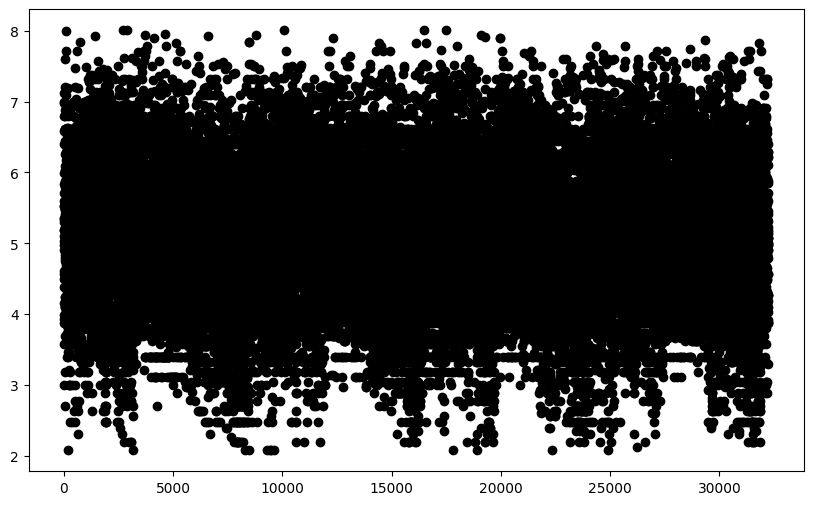

In [ ]:
# Código para criar o gráfico
plt.figure(figsize=(10, 6))

# Plotar os valores reais (y3)
plt.scatter(range(len(y3)), y3, color='black', label='Real Values (y3)')

# Plotar as previsões de treinamento, teste e validação
plt.scatter(range(len(y_train)), y_pred_train, color='blue', label='Train Predictions')
plt.scatter(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, color='green', label='Test Predictions')
plt.scatter(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, color='red', label='Validation Predictions')

plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Real vs. Predicted Values')
plt.legend()
plt.show()

In [ ]:
# Código para criar o gráfico de linha
plt.figure(figsize=(10, 6))

# Plotar os valores reais (y3) como uma linha preta
plt.plot(range(len(y3)), y3, color='black', label='Real Values (y3)')

# Plotar as previsões de treinamento, teste e validação como linhas com diferentes cores
plt.plot(range(len(y_train)), y_pred_train, color='blue', label='Train Predictions')

In [ ]:

# Código para criar o gráfico de linha
plt.figure(figsize=(10, 6))

# Plotar os valores reais (y3) como uma linha preta
plt.plot(range(len(y3)), y3, color='black', label='Real Values (y3)')

# Plotar as previsões de treinamento, teste e validação como linhas com diferentes cores
plt.plot(range(len(y_train)), y_pred_train, color='blue', label='Train Predictions')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, color='green', label='Test Predictions')
plt.plot(range(len(y_train) + len(y_test), len(y_train) + len(y_test) + len(y_val)), y_pred_val, color='red', label='Validation Predictions')

plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Real vs. Predicted Values (Line Chart)')
plt.legend()
plt.show()

In [ ]:
# vizualização gráfica das previsões

tabela_auxiliar = pd.DataFrame()
#tabela_auxiliar["Y de treino"] = y_pred_train
tabela_auxiliar["Y de teste"] = y_pred_test
tabela_auxiliar["Validação"] = y_pred_val

#display(tabela_auxiliar)
sns.lineplot(data=tabela_auxiliar)
plt.show()

In [ ]:
#y_pred_orig = exp()
y_pred_train

In [ ]:
# Criar um dicionário com os dados de erros
data = {
    'Test': y_pred_test,
    'Validation': y_pred_val
}

# Criar o DataFrame a partir do dicionário
df_erros= pd.DataFrame(data)
df_erros

In [ ]:
# análise gráfica dos resultados de teste

sns.histplot(df_erros['Test'])
plt.axvline(df_erros['Test'].mean(), color='red', label='média')

plt.title('Distribuição da variavel Test')
plt.show()

In [ ]:
# análise gráfica dos resultados da variavel target na validacao.

sns.histplot(df_erros['Validation'])
plt.axvline(df_erros['Validation'].mean(), color='red', label='média')

plt.title('Distribuição da variavel target na validação')
plt.show()

In [ ]:
df_y3 = pd.DataFrame(y3)
df_ypred_train = pd.DataFrame(y_pred_train)
df_ypred_test = pd.DataFrame(y_pred_test)
df_ypred_val = pd.DataFrame(y_pred_val)

In [ ]:
# Unir os DataFrames verticalmente
df_ttv = pd.concat([df_ypred_train, df_ypred_test, df_ypred_val], ignore_index=True)
len(df_ttv)

In [ ]:
len(df_y3)

In [ ]:
# vizualização gráfica das previsões

tabela_auxiliar = pd.DataFrame()
tabela_auxiliar["Y de predicoes"] = df_ttv
tabela_auxiliar["Y real"] = df_y3

#display(tabela_auxiliar)
sns.lineplot(data=tabela_auxiliar)
plt.show()

In [ ]:
df_ypred_train

In [ ]:
2.71**0.56


In [ ]:
#log 8  bas2 = 3

In [ ]:
#log y base10 = 0.27
10**0.27